# Peak Detection (ピーク検出)

`gwexpy` では、`TimeSeries` や `FrequencySeries` に含まれる信号のピークを簡単に検出するための `find_peaks` メソッドを提供しています。これは内部的に `scipy.signal.find_peaks` をラップしていますが、物理単位（Hz, 秒など）を用いた直感的なパラメータ指定が可能です。

`find_peaks` メソッドは、以下の2つを返します。
- **Peak Series**: ピーク点のみを抽出した新しい Series オブジェクト
- **Properties**: scipy が返すピーク特性（プロミネンスや幅など）の辞書


In [1]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from gwexpy import TimeSeries, FrequencySeries

plt.style.use("seaborn-v0_8-whitegrid")


/home/washimi/miniforge3/envs/ws-base/lib/python3.12/site-packages/gwpy/time/__init__.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import LIGOTimeGPS


## 1. FrequencySeries でのピーク検出


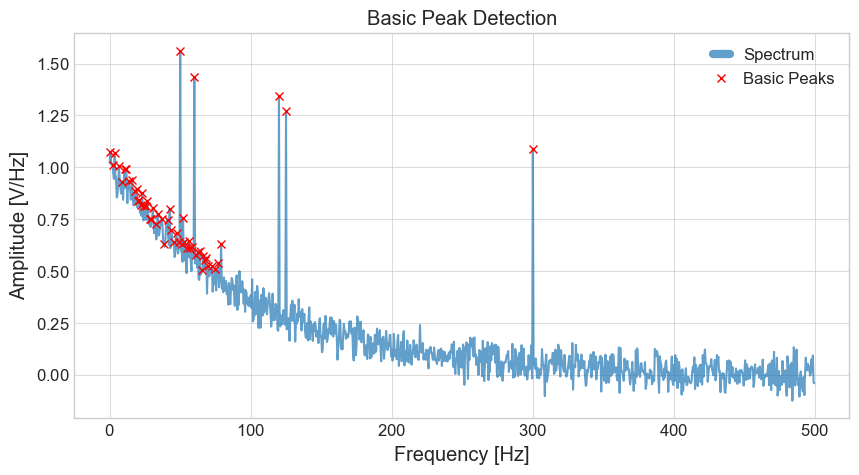

In [2]:
# 擬似データの作成
df = 0.5 * u.Hz
f_axis = np.arange(0, 500, df.value) * u.Hz
data = np.exp(-f_axis.value / 100) + np.random.normal(0, 0.05, len(f_axis))

# ピークを追加
peak_freqs_true = [50, 60, 120, 125, 300] * u.Hz
for f in peak_freqs_true:
    idx = int(f.value / df.value)
    data[idx] += 1.0

spec = FrequencySeries(data, df=df, unit="V/Hz")

# --- 基本的な検出 (しきい値のみ) ---
# peaks は FrequencySeries オブジェクトとして返ってきます
peaks, _ = spec.find_peaks(threshold=0.5)

plt.figure(figsize=(10, 5))
plt.plot(spec.frequencies, spec.value, label="Spectrum", alpha=0.7)
plt.plot(peaks.frequencies, peaks.value, "x", color="red", label="Basic Peaks")
plt.title("Basic Peak Detection")
plt.xlabel("Frequency [Hz]"); plt.ylabel("Amplitude [V/Hz]")
plt.legend(); plt.show()


## 2. 物理単位による制約 (Distance & Width)


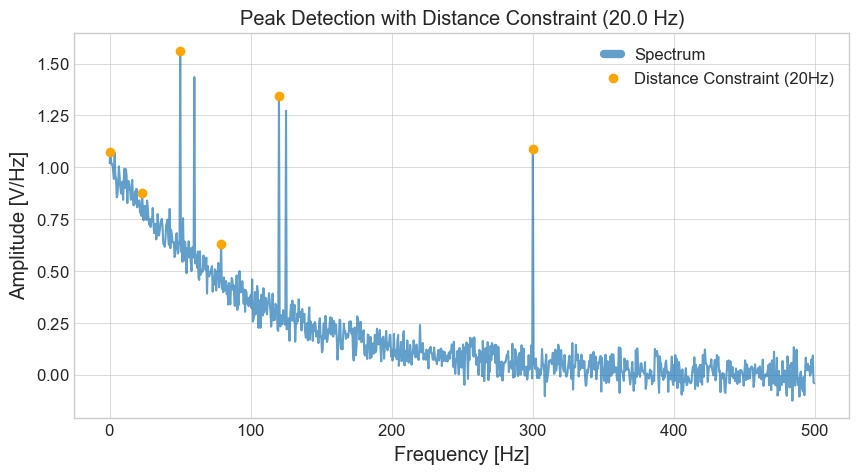

Detected peaks: [  0.5  23.   50.   79.  120.  300. ] Hz


In [3]:
dist_constraint = 20 * u.Hz
peaks_adv, props = spec.find_peaks(threshold=0.5, distance=dist_constraint)

plt.figure(figsize=(10, 5))
plt.plot(spec.frequencies, spec.value, label="Spectrum", alpha=0.7)
plt.plot(peaks_adv.frequencies, peaks_adv.value, "o", color="orange", label="Distance Constraint (20Hz)")
plt.title(f"Peak Detection with Distance Constraint ({dist_constraint})")
plt.xlabel("Frequency [Hz]"); plt.ylabel("Amplitude [V/Hz]")
plt.legend(); plt.show()

print(f"Detected peaks: {peaks_adv.frequencies}")


## 3. TimeSeries でのピーク検出


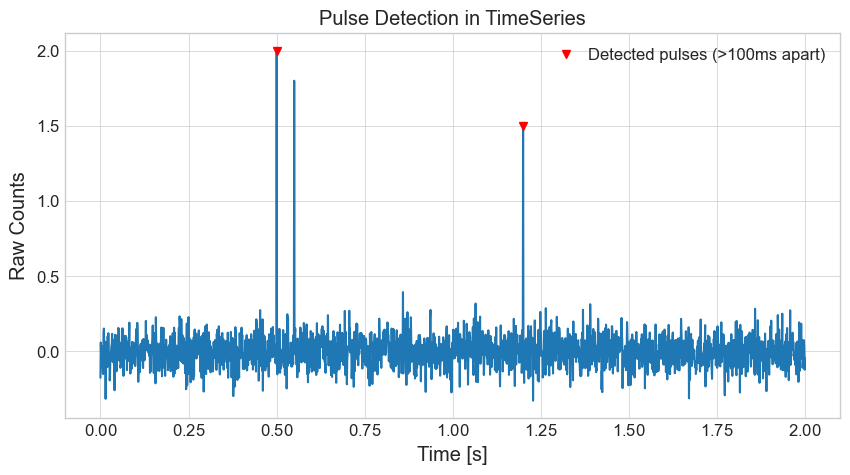

In [4]:
fs = 1024.0
t = np.arange(0, 2.0, 1/fs)
ts_data = np.random.normal(0, 0.1, len(t))

# パルスを追加
ts_data[int(0.5*fs)] = 2.0
ts_data[int(0.55*fs)] = 1.8
ts_data[int(1.2*fs)] = 1.5

ts = TimeSeries(ts_data, sample_rate=fs, unit="counts")

# 0.1秒以内の連続したパルスは無視する設定
peaks_t, _ = ts.find_peaks(height=0.5, distance=0.1 * u.s)

plt.figure(figsize=(10, 5))
plt.plot(ts.times, ts.value)
plt.plot(peaks_t.times, peaks_t.value, "v", color="red", label="Detected pulses (>100ms apart)")
plt.title("Pulse Detection in TimeSeries")
plt.xlabel("Time [s]"); plt.ylabel("Raw Counts")
plt.legend(); plt.show()
